In [39]:
import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
import seaborn as sns
# from traj_run import rho_ohmic
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S

In [40]:
# mother_folder0 = '/Users/ansatz/data/comp/sbm/vn_entropy_1site/24_07_04'
# mother_folder1 = '/Users/ansatz/data/comp/sbm/rho_check/'
todo_keys = ['s0.70-alpha0.05', 's0.7-alpha0.4', 's0.7-alpha0.8', 's0.30-alpha0.8', 's0.40-alpha0.8', 's0.50-alpha0.8']
mother_folder = '/Users/ansatz/data/comp/sbm/24_09_09'

In [41]:
vn_entropy_1site_all_lines ={}
# for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
#     points = { i_step : f"_{i_step}_step_entropy_1sites.pickle" for i_step in range(100) }
#     nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

#     rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])    
#     key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
#     print(key)
#     vn_entropy_1site_all_lines[key] = points
print('-----')
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(100) }
    nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

    rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])
    key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
    # print(key)
    vn_entropy_1site_all_lines[key] = points

-----


In [42]:
vn_entropy_1site_all_lines.keys()

dict_keys(['s0.30-alpha0.48-nmodes1000-rho0', 's0.30-alpha0.48-nmodes1000-rho1', 's0.30-alpha0.48-nmodes800-rho0', 's0.30-alpha0.48-nmodes800-rho1', 's0.40-alpha0.05-nmodes1000-rho0', 's0.40-alpha0.05-nmodes1000-rho1', 's0.40-alpha0.05-nmodes800-rho0', 's0.40-alpha0.05-nmodes800-rho1', 's0.40-alpha0.20-nmodes1000-rho0', 's0.40-alpha0.20-nmodes1000-rho1', 's0.40-alpha0.20-nmodes800-rho0', 's0.40-alpha0.20-nmodes800-rho1', 's0.40-alpha0.40-nmodes1000-rho0', 's0.40-alpha0.40-nmodes1000-rho1', 's0.40-alpha0.40-nmodes800-rho0', 's0.40-alpha0.40-nmodes800-rho1', 's0.40-alpha0.48-nmodes1000-rho0', 's0.40-alpha0.48-nmodes1000-rho1', 's0.40-alpha0.48-nmodes800-rho0', 's0.40-alpha0.48-nmodes800-rho1', 's0.50-alpha0.48-nmodes1000-rho0', 's0.50-alpha0.48-nmodes1000-rho1', 's0.50-alpha0.48-nmodes800-rho0', 's0.50-alpha0.48-nmodes800-rho1', 's0.70-alpha0.05-nmodes1000-rho0', 's0.70-alpha0.05-nmodes1000-rho1', 's0.70-alpha0.05-nmodes800-rho0', 's0.70-alpha0.05-nmodes800-rho1', 's0.70-alpha0.40-nmodes

In [43]:
def show_result_t_S(s, alpha, nmodes, rho_type, step_length=1):# -> tuple[list, list, list]:
    imodes = []
    ws = []
    freqs = []
    amps = []
    xfs = []
    fft_amps = []
    # s = 0.7
    # alpha = 0.05
    # nmodes = 1000
    # rho_type = 0
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    # key = f's{s:.02f}-alpha{alpha:.02f}'
    key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
    for i in range(0, nmodes, step_length):
        query_mode = i
        w, freq, amplitude, phase, xf, fft_amp = draw_t_S(pf, vn_entropy_1site_all_lines, key, query_mode)
        if w != 0 :
            imodes.append(query_mode)
            ws.append(w)
            freqs.append(freq)
            amps.append(amplitude)
            xfs.append(xf)
            fft_amps.append(fft_amp)
    return imodes, ws, freqs, amps, xfs, fft_amps, key

In [44]:
def show_fft_res(imodes, key, xfs, fft_amps, query_mode=None):
    plt.title(f'{key}')
    cuttoff_N = int(xfs[0].__len__() *0.001)
    print(cuttoff_N)
    if query_mode is None:
        for i in range(len(imodes)):
            imode = imodes[i]
            plt.plot(xfs[i][:cuttoff_N], fft_amps[i][:cuttoff_N], '-', label=f'mode v{imode}')
    else:
        i = imodes.index(query_mode)
        plt.plot(xfs[i][:cuttoff_N], fft_amps[i][:cuttoff_N], '-', label=f'mode v{query_mode}')
    plt.legend()

def show_w_freqs(key, ws, freqs):
    plt.title(f'w-freq:{key}')
    plt.plot(ws, freqs,'-')
    plt.plot(ws, freqs,'o')
    plt.xlabel('freq of phonon')
    plt.ylabel('freq of S')
    plt.xlim(0,10)
    plt.ylim(0,max(freqs))

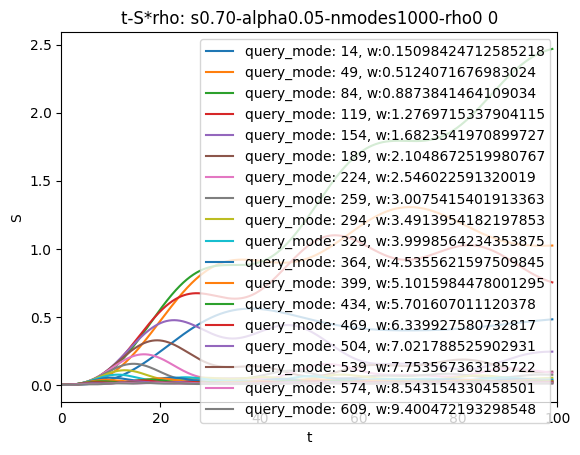

In [45]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.05, nmodes=1000, rho_type=0, step_length=7)

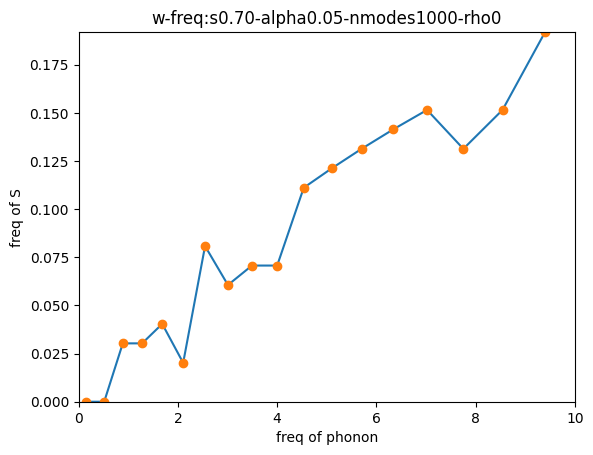

In [46]:
show_w_freqs(key, ws, freqs)

5


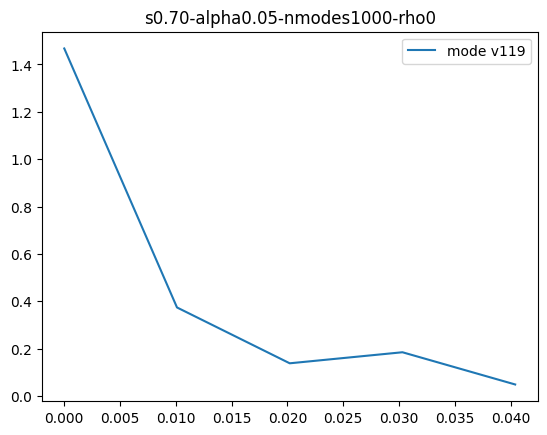

In [47]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=119)

In [ ]:
xfs[0].shape


In [ ]:
plt.plot(xfs[4])

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=224)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=294)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.4, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.8, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.3, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.5, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.05, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.2, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.4, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.3, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.3, alpha=0.48, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.48, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.5, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.5, alpha=0.48, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
assert 0

# W-S

In [ ]:
s = 0.7
alpha = 0.05
nmodes= 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
draw_w_S(pf, vn_entropy_1site_all_lines, key)

In [ ]:
s = 0.7
alpha = 0.40
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
draw_w_S(pf, vn_entropy_1site_all_lines, f's{s:.02f}-alpha{alpha:.02f}')

In [ ]:
s = 0.7
alpha = 0.80
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines, f's{s:.02f}-alpha{alpha:.02f}')

In [ ]:
s = 0.7
alpha = 0.05
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.4
nmodes = 1000
rho_type = 1 

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.8
nmodes = 1000
rho_type = 1 

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.3
alpha = 0.8
nmodes = 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines,  f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.4
alpha = 0.8
nmodes = 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.5
alpha = 0.8
nmodes = 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
freq_dict = {}
query_istep = 95

In [ ]:



s = 0.7
alpha = 0.05

pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)


for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
func = func_gentor(freq, amplitude, phase)


i_step = query_istep
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)


new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:



s = 0.7
alpha = 0.4

pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:



s = 0.7
alpha = 0.8

pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)



for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.05
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)
plt.clf()
new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')

plt.title('Ori and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.4
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.8
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:



s = 0.3
alpha = 0.8
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:



s = 0.4
alpha = 0.8
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:



s = 0.5
alpha = 0.8
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:
freq_dict

In [ ]:
for key in freq_dict:
    print(key, 1/freq_dict[key])

In [ ]:

T = (x_uniform.max() - x_uniform.min()) / N  # sample Time
yf = fft(signal_uniform)
xf = fftfreq(N, T)[:N//2]


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, signal, 'o', label='Original Signal')
plt.plot(x_uniform, signal_uniform, '-', label='Interpolated Signal')
plt.title('Original and Interpolated Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()


In [ ]:
# map
fft_amp = 2.0/N *np.abs(yf[:N//2])
plt.subplot(2, 1, 2)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('FFT of the Interpolated Signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [ ]:
indexs , _= scipy.signal.find_peaks(fft_amp)
index = indexs[0]
index

In [ ]:
freq = main_freq = xf[index]
freq

In [ ]:
amplitude = 2.0/N * np.abs(yf[index])
phase = np.angle(yf[index])

In [ ]:
def func_gentor(freq, phase):

    def signal_func(x, a, b, c,  d, amp):
        return a * np.exp(-b* (x**c) + amp * np.sin(2.0 * np.pi * freq * x + phase))  + d

    return signal_func

In [ ]:
func = func_gentor(freq, phase)


In [ ]:
# x = x.tolist()
# signal = signal.tolist()

popt, pcov = scipy.optimize.curve_fit(func, x.ravel(), signal.ravel())

In [ ]:
pcov

In [ ]:
2.0 * np.pi * freq

In [ ]:
newy = func(x, popt[0], popt[1], popt[2], popt[3])
# T = (x_uniform.max() - x_uniform.min()) / N  # 采样间隔
# yf = fft(signal_uniform)
# xf = fftfreq(N, T)[:N//2]


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, signal, 'o', label='Original Signal')
plt.plot(x, newy, '-', label='Func Signal')
plt.title('Original and Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()


In [ ]:
amp

In [ ]:
! pip install PyWavelets

In [ ]:
import pywt

In [ ]:

coeffs = pywt.wavedec(signal_uniform, 'db1', level=6)

In [ ]:
fig, ax = plt.subplots(len(coeffs), 1, figsize=(10, 12))
for i, coeff in enumerate(coeffs):
    ax[i].plot(coeff)
    ax[i].set_title(f'Level {i} Coefficients')
plt.tight_layout()
plt.show()

In [ ]:
xf.shape[0]

In [ ]:
vn_entropy_1site_all_lines.keys()

In [ ]:
key

In [ ]:
mother_folder0

In [17]:
from data_analysis import rho_ohmic, translate_param
s= 0.7
alpha =0.8
omega_c = 10
Omega = 1
rho_type= 1
nmodes = 1000

In [ ]:
s_reno, alpha_reno, omega_c_reno = translate_param(s, alpha, omega_c, Omega)
sdf = rho_ohmic(alpha_reno, omega_c_reno, s_reno, rho_type)
w, c2 = sdf.Wang1(nmodes)
w[w<10].shape

In [21]:
w_eff = w[w < 10]

In [ ]:
w_eff.shape

In [ ]:
w_eff.shape[0]/w.shape[0]

In [ ]:
w_eff